In [2]:
#%%
# ==============================================================================
# CELL 1: Import Libraries
# ==============================================================================
"""
Import necessary libraries for data manipulation, visualization, and statistical testing.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For ANOVA/Kruskal-Wallis
import os

# Optional: For advanced post-hoc tests if Kruskal-Wallis is significant
# You might run this in a separate cell once if needed:
# !pip install scikit-posthocs
try:
    import scikit_posthocs as sp
    SCIKIT_POSTHOCS_INSTALLED = True
    print("scikit-posthocs library successfully imported.")
except ImportError:
    SCIKIT_POSTHOCS_INSTALLED = False
    print("scikit-posthocs library not installed. Dunn's post-hoc test will not be available.")
    print("Consider installing it: pip install scikit-posthocs")


# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)

print("\nLibraries imported.")

scikit-posthocs library not installed. Dunn's post-hoc test will not be available.
Consider installing it: pip install scikit-posthocs

Libraries imported.


In [3]:
#%%
# ==============================================================================
# CELL 2: Load Cleaned Datasets
# ==============================================================================
"""
Load the cleaned CSV files for Benin, Sierra Leone, and Togo.
These files should have been generated during Task 2.
Includes robust path handling.
"""
# Function to get data path (can be moved to a utils.py later)
def get_data_path(filename, base_data_dir="data"):
    path_notebook_style = f"../{base_data_dir}/{filename}" # If notebook is in notebooks/
    path_root_style = f"{base_data_dir}/{filename}"     # If notebook is in project root

    if os.path.exists(path_notebook_style):
        return path_notebook_style
    elif os.path.exists(path_root_style):
        return path_root_style
    else:
        print(f"Warning: File '{filename}' not found at '{path_notebook_style}' or '{path_root_style}'.")
        return None

# Define filenames
benin_clean_file = "benin_clean.csv"
sierraleone_clean_file = "sierraleone_clean.csv"
togo_clean_file = "togo_clean.csv"

# Load data
dfs_clean = {}
all_data_loaded = True

for country_name, filename in zip(["Benin", "Sierra Leone", "Togo"],
                                  [benin_clean_file, sierraleone_clean_file, togo_clean_file]):
    file_path = get_data_path(filename)
    if file_path:
        try:
            # Assuming 'Timestamp' was set as index and needs to be parsed as dates
            dfs_clean[country_name] = pd.read_csv(file_path, index_col='Timestamp', parse_dates=True)
            print(f"Successfully loaded cleaned data for {country_name} from: {file_path}")
        except Exception as e:
            print(f"Error loading cleaned data for {country_name} from '{file_path}': {e}")
            all_data_loaded = False
            dfs_clean[country_name] = pd.DataFrame() # Assign empty df on error
    else:
        all_data_loaded = False
        dfs_clean[country_name] = pd.DataFrame() # Assign empty df if path not found

if not all_data_loaded:
    print("\nCritical Error: One or more cleaned datasets could not be loaded.")
    print("Please ensure all '_clean.csv' files from Task 2 are present in the 'data/' directory.")
    print("Further analysis in this notebook might be incomplete or fail.")
else:
    print("\nAll cleaned datasets loaded successfully.")

# Display shapes to confirm loading
if all_data_loaded:
    for name, df_c in dfs_clean.items():
        print(f"Shape of {name} cleaned data: {df_c.shape}")

Successfully loaded cleaned data for Benin from: ../data/benin_clean.csv
Successfully loaded cleaned data for Sierra Leone from: ../data/sierraleone_clean.csv
Successfully loaded cleaned data for Togo from: ../data/togo_clean.csv

All cleaned datasets loaded successfully.
Shape of Benin cleaned data: (525600, 18)
Shape of Sierra Leone cleaned data: (525600, 18)
Shape of Togo cleaned data: (525600, 18)


In [4]:
#%%
# ==============================================================================
# CELL 3: Combine DataFrames for Comparison
# ==============================================================================
"""
Add a 'Country' column to each DataFrame.
Then, concatenate them into a single DataFrame for easier plotting and aggregation.
Only proceed if all data was loaded successfully.
"""
df_combined = pd.DataFrame() # Initialize

if all_data_loaded:
    df_list_for_concat = []
    for country_name, df_country_clean in dfs_clean.items():
        if not df_country_clean.empty:
            temp_df = df_country_clean.copy()
            temp_df['Country'] = country_name
            df_list_for_concat.append(temp_df)
        else:
            print(f"Warning: DataFrame for {country_name} is empty, skipping concatenation for this country.")

    if df_list_for_concat:
        df_combined = pd.concat(df_list_for_concat, ignore_index=False) # Keep original Timestamp index if useful
        print("\nCombined DataFrame created successfully.")
        print("Head of combined DataFrame:")
        display(df_combined.head())
        print("\nTail of combined DataFrame:")
        display(df_combined.tail())
        print(f"\nShape of combined DataFrame: {df_combined.shape}")
        print(f"Unique countries in combined DataFrame: {df_combined['Country'].unique()}")
    else:
        print("Error: No valid DataFrames to combine. Cannot proceed with combined analysis.")
else:
    print("Skipping data combination due to previous loading errors.")




Combined DataFrame created successfully.
Head of combined DataFrame:


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
Timestamp,,,,,,,,,,,,,,,,,,,
2021-08-09 00:01:00,0.000,0.000,0.000,0.000,0.000,26.200,93.400,0.000,0.400,0.100,122.100,0.000,998.000,0,0.000,26.300,26.200,NaN,Benin
2021-08-09 00:02:00,0.000,0.000,0.000,0.000,0.000,26.200,93.600,0.000,0.000,0.000,0.000,0.000,998.000,0,0.000,26.300,26.200,NaN,Benin
2021-08-09 00:03:00,0.000,0.000,0.000,0.000,0.000,26.200,93.700,0.300,1.100,0.500,124.600,1.500,997.000,0,0.000,26.400,26.200,NaN,Benin
2021-08-09 00:04:00,0.000,0.000,0.000,0.000,0.000,26.200,93.300,0.200,0.700,0.400,120.300,1.300,997.000,0,0.000,26.400,26.300,NaN,Benin
2021-08-09 00:05:00,0.000,0.000,0.000,0.000,0.000,26.200,93.300,0.100,0.700,0.300,113.200,1.000,997.000,0,0.000,26.400,26.300,NaN,Benin



Tail of combined DataFrame:


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
Timestamp,,,,,,,,,,,,,,,,,,,
2022-10-24 23:56:00,0.000,0.000,0.000,0.000,0.000,25.200,53.800,0.000,0.000,0.000,0.000,0.000,977.000,0,0.000,24.300,24.000,NaN,Togo
2022-10-24 23:57:00,0.000,0.000,0.000,0.000,0.000,25.300,53.500,0.000,0.000,0.000,0.000,0.000,977.000,0,0.000,24.300,24.000,NaN,Togo
2022-10-24 23:58:00,0.000,0.000,0.000,0.000,0.000,25.300,53.400,0.000,0.000,0.000,0.000,0.000,977.000,0,0.000,24.200,23.900,NaN,Togo
2022-10-24 23:59:00,0.000,0.000,0.000,0.000,0.000,25.400,53.500,0.000,0.000,0.000,0.000,0.000,977.000,0,0.000,24.100,23.800,NaN,Togo
2022-10-25 00:00:00,0.000,0.000,0.000,0.000,0.000,25.400,52.300,0.000,0.000,0.000,0.000,0.000,977.000,0,0.000,24.100,23.800,NaN,Togo



Shape of combined DataFrame: (1576800, 19)
Unique countries in combined DataFrame: ['Benin' 'Sierra Leone' 'Togo']



--- Generating Boxplots for Key Metrics ---


/tmp/ipykernel_781822/3427230667.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_781822/3427230667.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_781822/3427230667.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_781822/3427230667.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


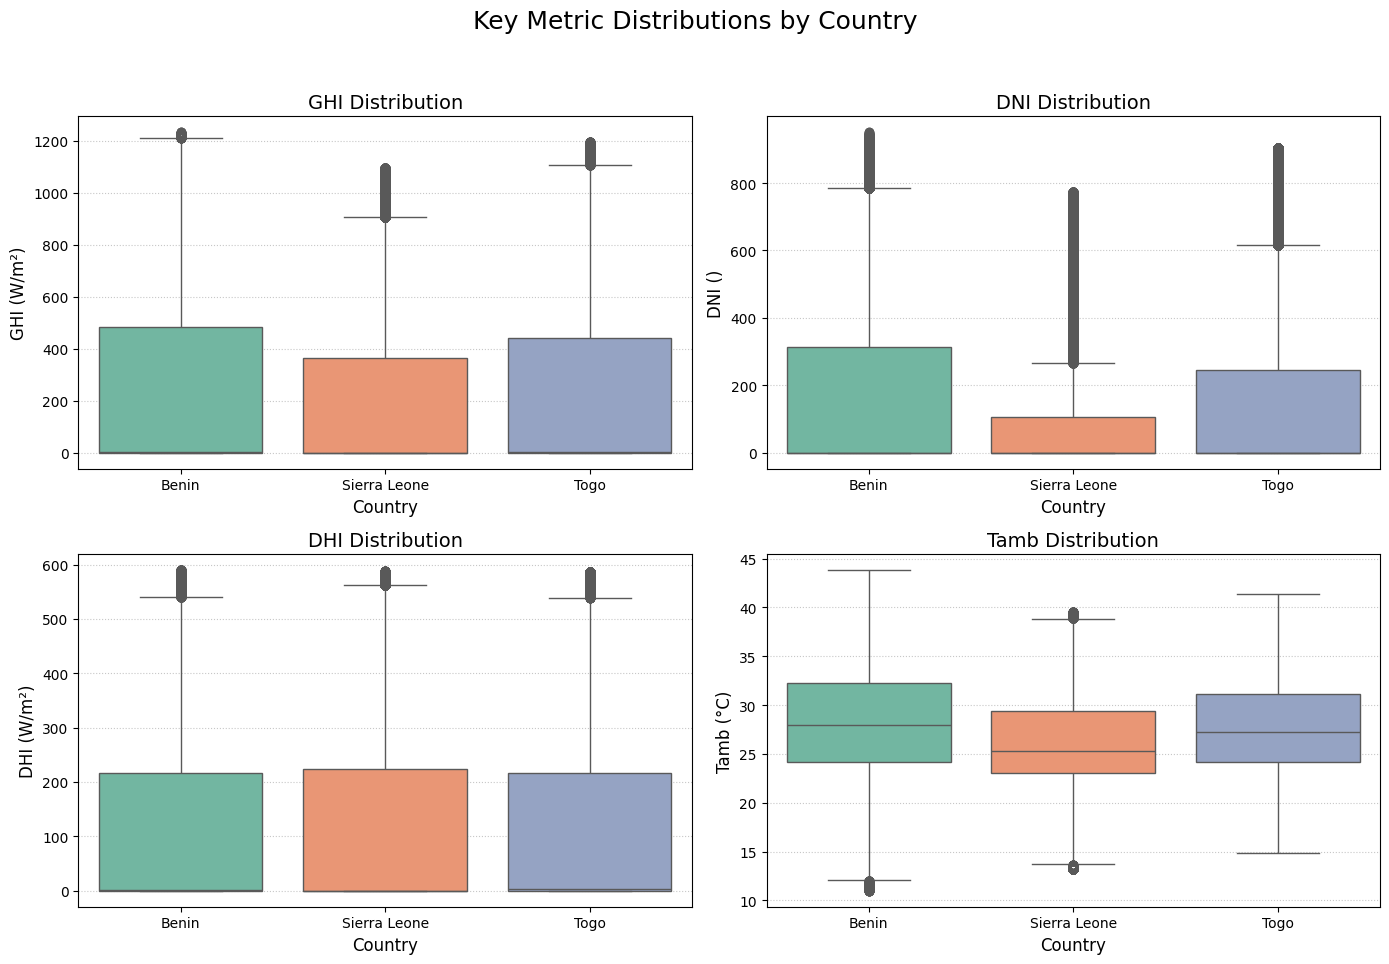

In [5]:
#%% [markdown]
# ## 1. Metric Comparison
# We will compare key solar irradiance metrics (GHI, DNI, DHI) and potentially
# other relevant environmental variables like Ambient Temperature (Tamb) across the three countries.

#%%
# ==============================================================================
# CELL 4: Boxplots for GHI, DNI, DHI, and Tamb
# ==============================================================================
"""
Generate side-by-side boxplots for GHI, DNI, DHI, and Tamb,
colored by country, to visualize their distributions and compare medians,
quartiles, and potential outliers.
"""
if not df_combined.empty:
    print("\n--- Generating Boxplots for Key Metrics ---")
    
    # Define metrics to consider for boxplots
    metrics_to_plot_boxplot = ['GHI', 'DNI', 'DHI', 'Tamb']
    
    # Filter metrics that are actually in the DataFrame
    metrics_present_boxplot = [m for m in metrics_to_plot_boxplot if m in df_combined.columns]

    if metrics_present_boxplot:
        num_plots_bp = len(metrics_present_boxplot)
        num_cols_bp_subplot = 2
        num_rows_bp_subplot = int(np.ceil(num_plots_bp / num_cols_bp_subplot))

        plt.figure(figsize=(7 * num_cols_bp_subplot, 5 * num_rows_bp_subplot))
        plt.suptitle('Key Metric Distributions by Country', fontsize=18, y=0.96)

        for i, metric in enumerate(metrics_present_boxplot):
            plt.subplot(num_rows_bp_subplot, num_cols_bp_subplot, i + 1)
            sns.boxplot(
                data=df_combined,
                x='Country',
                y=metric,
                palette='Set2',
                showfliers=True  # Set to False if you want to hide outliers
            )

            # Auto-assign unit
            unit = 'W/m²' if any(k in metric for k in ['HI', 'Mod']) else '°C' if 'T' in metric else ''
            plt.title(f'{metric} Distribution', fontsize=14)
            plt.ylabel(f'{metric} ({unit})', fontsize=12)
            plt.xlabel('Country', fontsize=12)
            plt.xticks(rotation=0, ha='center')
            plt.grid(True, linestyle=':', alpha=0.7, axis='y')

        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

    else:
        print("No valid metrics found in the combined DataFrame for boxplot comparison.")
else:
    print("Skipping boxplots as the combined DataFrame is empty or not created.")



In [6]:
#%%
# ==============================================================================
# CELL 5: Summary Table (Mean, Median, Standard Deviation)
# ==============================================================================
"""
Create a summary table comparing the mean, median, and standard deviation
of GHI, DNI, and DHI across the three countries.
"""
if not df_combined.empty:
    print("\n--- Summary Table for GHI, DNI, DHI ---")
    summary_metrics_table = ['GHI', 'DNI', 'DHI']
    # Filter for metrics present in df_combined
    summary_metrics_present_table = [m for m in summary_metrics_table if m in df_combined.columns]

    if summary_metrics_present_table:
        # Calculate stats only for daytime values for irradiance to make means more comparable
        # Define "daytime" as GHI > some threshold, e.g., 10 W/m^2
        df_daytime_combined = df_combined[df_combined.get('GHI', 0) > 10] if 'GHI' in df_combined else df_combined

        if not df_daytime_combined.empty:
            summary_stats_daytime = df_daytime_combined.groupby('Country')[summary_metrics_present_table].agg(['mean', 'median', 'std'])
            print("\nSummary Statistics (Mean, Median, Std) for Daytime (GHI > 10 W/m²):")
            display(summary_stats_daytime.style.format("{:.2f}").set_caption("Daytime Irradiance Statistics by Country"))
        else:
            print("No daytime data found (GHI > 10 W/m²). Showing overall statistics.")
            summary_stats_overall = df_combined.groupby('Country')[summary_metrics_present_table].agg(['mean', 'median', 'std'])
            print("\nOverall Summary Statistics (Mean, Median, Std):")
            display(summary_stats_overall.style.format("{:.2f}").set_caption("Overall Irradiance Statistics by Country"))
            
    else:
        print("GHI, DNI, or DHI not found in the combined DataFrame for summary table.")
else:
    print("Skipping summary table as combined DataFrame is empty or not created.")


--- Summary Table for GHI, DNI, DHI ---

Summary Statistics (Mean, Median, Std) for Daytime (GHI > 10 W/m²):


In [7]:
#%%
# ==============================================================================
# CELL 6: Statistical Testing for GHI Differences
# ==============================================================================
"""
Perform a Kruskal-Wallis H-test (a non-parametric alternative to one-way ANOVA)
to determine if there are statistically significant differences in GHI distributions
among the three countries. Note p-values.
"""
if not df_combined.empty and 'GHI' in df_combined.columns and 'Country' in df_combined.columns:
    print("\n--- Statistical Testing for GHI Differences ---")
    
    # Prepare list of GHI arrays for each country
    # Using the full dataset for GHI distribution comparison
    ghi_data_groups = []
    country_names_for_test = []
    for country_name in dfs_clean.keys(): # Use original dfs_clean to ensure clean groups
        if country_name in df_combined['Country'].unique() and not dfs_clean[country_name].empty and 'GHI' in dfs_clean[country_name].columns:
            ghi_values = dfs_clean[country_name]['GHI'].dropna()
            if len(ghi_values) > 1: # Kruskal-Wallis needs at least some data per group
                ghi_data_groups.append(ghi_values)
                country_names_for_test.append(country_name)
            else:
                print(f"Not enough GHI data for {country_name} to include in test.")
        else:
            print(f"Skipping {country_name} from test (not in combined df, empty, or no GHI).")


    if len(ghi_data_groups) >= 2: # Need at least two groups for the test
        print(f"\nPerforming Kruskal-Wallis H-test for GHI across: {', '.join(country_names_for_test)}")
        try:
            statistic_kw, p_value_kw = stats.kruskal(*ghi_data_groups) # Unpack the list of arrays
            print(f"  Kruskal-Wallis Statistic: {statistic_kw:.4f}")
            print(f"  P-value: {p_value_kw:.4g}") # .4g for better formatting of small p-values

            if p_value_kw < 0.05:
                print("  Conclusion: The differences in GHI medians between the countries are statistically significant (p < 0.05).")
                if SCIKIT_POSTHOCS_INSTALLED and len(ghi_data_groups) > 2:
                    print("\n  Performing Dunn's Post-Hoc Test (Bonferroni adjusted p-values):")
                    # Need to pass original data in a format posthoc_dunn expects (e.g., from a combined df or list of lists/arrays)
                    # For simplicity, if using a list of arrays like ghi_data_groups:
                    dunn_results = sp.posthoc_dunn(ghi_data_groups, p_adjust='bonferroni')
                    # Set row and column names for the results table
                    dunn_results.columns = country_names_for_test
                    dunn_results.index = country_names_for_test
                    display(dunn_results.style.set_caption("Dunn's Test: Pairwise GHI Comparisons (p-values)"))
                elif not SCIKIT_POSTHOCS_INSTALLED and len(ghi_data_groups) > 2:
                    print("  (Consider installing scikit-posthocs for Dunn's post-hoc test to identify specific differing pairs.)")
            else:
                print("  Conclusion: No statistically significant difference found in GHI medians between the countries (p >= 0.05).")
        except Exception as e:
            print(f"  Error during Kruskal-Wallis test: {e}")
    else:
        print("Not enough country groups with valid GHI data (need at least 2) to perform Kruskal-Wallis test.")
else:
    print("Skipping statistical testing as combined DataFrame is empty, or GHI/Country columns are missing.")



--- Statistical Testing for GHI Differences ---

Performing Kruskal-Wallis H-test for GHI across: Benin, Sierra Leone, Togo
  Kruskal-Wallis Statistic: 1415.8894
  P-value: 3.496e-308
  Conclusion: The differences in GHI medians between the countries are statistically significant (p < 0.05).
  (Consider installing scikit-posthocs for Dunn's post-hoc test to identify specific differing pairs.)



"""
### Key Observations from Cross-Country Comparison

Based on the comparative analysis of solar irradiance components and ambient temperature (refer to Figure X - *your boxplot figure showing GHI, DNI, DHI, Tamb distributions*):

*   **Superior Solar Resource in Benin:** Benin demonstrates the most favorable overall solar resource profile among the three nations. It exhibits the highest median Global Horizontal Irradiance (GHI), indicating the greatest total solar energy available. Crucially, Benin also shows significantly higher median Direct Normal Irradiance (DNI) with a wider interquartile range, suggesting more abundant and consistent direct sunlight suitable for high-efficiency PV systems and potentially tracking technologies. The Kruskal-Wallis test for GHI [should be confirmed by your actual test result: *e.g., confirmed these differences as statistically significant (p < 0.001), with post-hoc tests indicating Benin's GHI is significantly higher than Sierra Leone's and Togo's.*]

*   **Sierra Leone Characterized by Diffuse Light and Moderate Temperatures:** Sierra Leone presents a distinct environmental profile with the lowest median GHI and DNI, but the highest median Diffuse Horizontal Irradiance (DHI). This strongly suggests a climate with more frequent cloud cover or atmospheric haze, making it more reliant on capturing diffuse sunlight. However, a potential advantage for Sierra Leone is its noticeably lower median ambient temperature and a more compressed temperature range, which could contribute to better solar panel operational efficiency by mitigating heat-related losses.

*   **Togo's Mixed Profile with High DNI Potential and Temperature Considerations:** Togo offers a competitive solar resource, with its median GHI positioned between Benin and Sierra Leone, and a DNI profile that is substantially better than Sierra Leone's, indicating good potential for direct sunlight capture during clear periods. However, Togo, similar to Benin, experiences higher median ambient temperatures and a wider temperature range, which would need to be carefully considered in technology selection and performance modeling to account for potential efficiency reductions at higher operational temperatures.
"""


--- Bar Chart Ranking by Average Daytime GHI ---


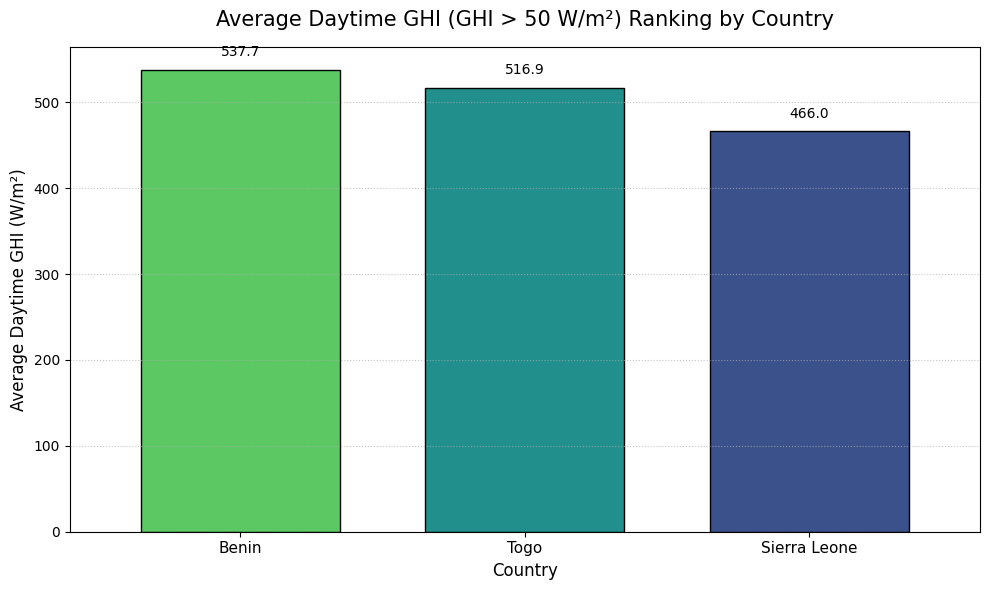

In [9]:
#%%
# ==============================================================================
# CELL 8:  Bar Chart Ranking by Average GHI
# ==============================================================================
"""
Create a bar chart to visually rank the countries by their average GHI.
It's often more informative to use average *daytime* GHI for this.
"""
if not df_combined.empty and 'GHI' in df_combined.columns and 'Country' in df_combined.columns:
    print("\n--- Bar Chart Ranking by Average Daytime GHI ---")

    # Calculate mean GHI only during potential productive hours (e.g., GHI > 50 W/m^2)
    # This avoids nighttime zeros heavily skewing the mean if datasets have different night/day ratios.
    df_daytime_for_ranking = df_combined[df_combined.get('GHI', 0) > 50]

    if not df_daytime_for_ranking.empty:
        avg_daytime_ghi = df_daytime_for_ranking.groupby('Country')['GHI'].mean().sort_values(ascending=False)

        if not avg_daytime_ghi.empty:
            plt.figure(figsize=(10, 6)) # Adjusted size
            # Create a color palette
            colors = sns.color_palette("viridis_r", len(avg_daytime_ghi)) # Reversed viridis

            bars = avg_daytime_ghi.plot(kind='bar', color=colors, edgecolor='black', width=0.7)
            plt.title('Average Daytime GHI (GHI > 50 W/m²) Ranking by Country', fontsize=15, pad=15)
            plt.ylabel('Average Daytime GHI (W/m²)', fontsize=12)
            plt.xlabel('Country', fontsize=12)
            plt.xticks(rotation=0, ha='center', fontsize=11)
            plt.yticks(fontsize=10)
            plt.grid(True, linestyle=':', alpha=0.7, axis='y')

            # Add value labels on top of bars
            for bar in bars.patches:
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bar.get_height() + (0.01 * df_daytime_for_ranking['GHI'].max()), # Dynamic offset
                         f'{bar.get_height():.1f}',
                         ha='center', va='bottom', fontsize=10, color='black')
            
            plt.tight_layout()
            plt.show()
        else:
            print("Could not calculate average daytime GHI for ranking (all groups might be empty after GHI > 50 filter).")
    else:
        print("No daytime GHI data (GHI > 50 W/m^2) available in the combined DataFrame for ranking.")
else:
    print("Skipping bonus bar chart ranking as combined DataFrame is empty or GHI/Country columns are missing.")